# Sound Analysis
## Measurements

In the following cells, I will calculate: <br>
* Sound Event Density 
* Loudness Level Average

In [ ]:
#!pip install "numpy<2.0"


In [1]:
import pandas as pd
import os
import xml.etree.ElementTree as ET
from lxml import etree
import pandas as pd
from nltk.tokenize import word_tokenize
import re
import string
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
#!pip install plotly kaleido lxml



In [2]:
# Load CSV into DataFrame
csv_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Erlangen/20250521_Vortrag/DNov_metadata.csv'  # Update with the path to your CSV file
csv_df = pd.read_csv(csv_path)

# Remove file extensions from filenames in the CSV DataFrame
csv_df['filename'] = csv_df['filename'].str.replace('.xml', '')


In [3]:
folder_path = '/Users/sguhr/Downloads/Literary_Soundscapes-main-2/loudness_predicted_DNov'

## Sound Event Density and Measurement of Loudness Level Average
Given is a sound event annotated XML file provided as a pandas data frame.
In the following, I count the number of words in the XML files excluding the XML elements. 
I further extract the XML content which are the sound event spans, separately for ambient and character sound events, and save them in two separate columns together with their assigned loudness level as dictionaries, having the spans as keys and the loudness level as values. 
Then, I tokenize the dictionary keys, save the tokenized copy to a further data frame column, and calculate the average size of a sound event in words. 

Furthermore, the loudness values of the separate dictionaries are summed up for each text and divided by the total number of loudness labeled sound events, for calculating the average loudness level of a texts character sound events, ambient sound events, and all sound events separately.
csv_df

In [4]:


def extract_sound_spans(xml_content):
    sound_spans = {'character_sound': {}, 'ambient_sound': {}}
    root = ET.fromstring(xml_content)

    ns = {'tei': 'http://www.tei-c.org/ns/1.0'}  # Define the namespace

    for elem in root.iter():
        if elem.tag.endswith('character_sound') or elem.tag.endswith('ambient_sound'):
            sound_text = elem.text.strip() if elem.text else ""
            loudness_str = elem.attrib.get('loudness', np.nan)
            loudness = float(loudness_str) if loudness_str != 'S' else np.nan
            tokenized_text = word_tokenize(sound_text, language='english')
            filtered_tokens = [token for token in tokenized_text if token not in string.punctuation]
            sound_spans[elem.tag.split('}')[1].rstrip('_')][tuple(filtered_tokens)] = loudness
    return sound_spans

def calculate_word_token_length(text):
    text_without_tags = re.sub(r'<[^>]+>', '', text)
    tokens = word_tokenize(text_without_tags, language='english')
    filtered_tokens = [token for token in tokens if token not in string.punctuation]
    return len(filtered_tokens)

def calculate_avg_loudness(sound_spans):
    loudness_values = [v for v in sound_spans.values() if not np.isnan(v)]
    return round(sum(loudness_values) / len(loudness_values), 2) if loudness_values else 0

def calculate_std_loudness(sound_spans):
    loudness_values = [v for v in sound_spans.values() if not np.isnan(v)]
    return round(np.std(loudness_values), 2) if loudness_values else 0

def calculate_std_token_count(sound_spans):
    token_counts = [len(k) for k, v in sound_spans.items() if not np.isnan(v)]
    return round(np.std(token_counts), 2) if token_counts else 0

def process_xml_file(filepath):
    character_sound_spans = {}
    ambient_sound_spans = {}
    word_token_length = 0
    character_loudness_count_all = 0
    ambient_loudness_count_all = 0
    character_se_count_without_nan = 0
    ambient_se_count_without_nan = 0
    
    with open(filepath, 'r', encoding='utf-8') as file:
        xml_content = file.read()
        sound_spans = extract_sound_spans(xml_content)
        character_sound_spans = sound_spans['character_sound']
        ambient_sound_spans = sound_spans['ambient_sound']
        word_token_length = calculate_word_token_length(xml_content)
        
        for elem in ET.fromstring(xml_content).iter():
            if elem.tag.endswith('character_sound'):
                character_loudness_count_all += 1
                if 'loudness' in elem.attrib and elem.attrib['loudness'] == 'S':
                    character_loudness_count_all -= 1
                if 'loudness' in elem.attrib and not np.isnan(float(elem.attrib['loudness'])):
                    character_se_count_without_nan += 1
            elif elem.tag.endswith('ambient_sound'):
                ambient_loudness_count_all += 1
                if 'loudness' in elem.attrib and elem.attrib['loudness'] == 'S':
                    ambient_loudness_count_all -= 1
                if 'loudness' in elem.attrib and not np.isnan(float(elem.attrib['loudness'])):
                    ambient_se_count_without_nan += 1
    
    # Averages including NaNs
    character_avg_token_count_with_nan = round(sum(len(key) for key in character_sound_spans.keys()) / len(character_sound_spans) if character_sound_spans else 0, 2)
    ambient_avg_token_count_with_nan = round(sum(len(key) for key in ambient_sound_spans.keys()) / len(ambient_sound_spans) if ambient_sound_spans else 0, 2)
    total_avg_token_count_with_nan = round(((sum(len(key) for key in character_sound_spans.keys()) if character_sound_spans else 0) +
                                           (sum(len(key) for key in ambient_sound_spans.keys()) if ambient_sound_spans else 0)) /
                                          ((len(character_sound_spans) if character_sound_spans else 0) + (len(ambient_sound_spans) if ambient_sound_spans else 0)), 2)
    
    # Averages excluding NaNs
    character_avg_token_count_without_nan = round(sum(len(key) for key in character_sound_spans.keys() if not np.isnan(character_sound_spans[key])) / len(character_sound_spans) if character_sound_spans else 0, 2)
    ambient_avg_token_count_without_nan = round(sum(len(key) for key in ambient_sound_spans.keys() if not np.isnan(ambient_sound_spans[key])) / len(ambient_sound_spans) if ambient_sound_spans else 0, 2)
    total_avg_token_count_without_nan = round(((sum(len(key) for key in character_sound_spans.keys() if not np.isnan(character_sound_spans[key])) if character_sound_spans else 0) +
                                               (sum(len(key) for key in ambient_sound_spans.keys() if not np.isnan(ambient_sound_spans[key])) if ambient_sound_spans else 0)) /
                                              ((len(character_sound_spans) if character_sound_spans else 0) + (len(ambient_sound_spans) if ambient_sound_spans else 0)), 2)

    # Std dev for token counts excluding NaNs
    character_token_count_std_without_nan = calculate_std_token_count(character_sound_spans)
    ambient_token_count_std_without_nan = calculate_std_token_count(ambient_sound_spans)
    combined_token_counts = [len(k) for k, v in {**character_sound_spans, **ambient_sound_spans}.items() if not np.isnan(v)]
    total_token_count_std_without_nan = round(np.std(combined_token_counts), 2) if combined_token_counts else 0

    # t_se averages
    t_se_aver = round(word_token_length / total_avg_token_count_with_nan, 2) if total_avg_token_count_with_nan != 0 else 0
    t_se_aver_without_nan = round(word_token_length / total_avg_token_count_without_nan, 2) if total_avg_token_count_without_nan != 0 else 0

    return (character_sound_spans, ambient_sound_spans, word_token_length,
            character_loudness_count_all, ambient_loudness_count_all, t_se_aver,
            character_avg_token_count_with_nan, ambient_avg_token_count_with_nan, total_avg_token_count_with_nan,
            character_avg_token_count_without_nan, ambient_avg_token_count_without_nan, total_avg_token_count_without_nan,
            t_se_aver_without_nan, character_se_count_without_nan, ambient_se_count_without_nan,
            (character_se_count_without_nan + ambient_se_count_without_nan),
            character_token_count_std_without_nan, ambient_token_count_std_without_nan, total_token_count_std_without_nan)

def process_folder(folder_path):
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            filepath = os.path.join(folder_path, filename)
            (character_sound_spans, ambient_sound_spans, word_token_length,
             character_loudness_count_all, ambient_loudness_count_all, t_se_aver,
             character_avg_token_count_with_nan, ambient_avg_token_count_with_nan, total_avg_token_count_with_nan,
             character_avg_token_count_without_nan, ambient_avg_token_count_without_nan, total_avg_token_count_without_nan,
             t_se_aver_without_nan, character_se_count_without_nan, ambient_se_count_without_nan, total_se_count_without_nan,
             character_token_count_std_without_nan, ambient_token_count_std_without_nan, total_token_count_std_without_nan) = process_xml_file(filepath)
            
            character_avg_loudness = calculate_avg_loudness(character_sound_spans)
            ambient_avg_loudness = calculate_avg_loudness(ambient_sound_spans)
            text_loudness_average = round((character_avg_loudness + ambient_avg_loudness) / 2, 2)
            
            character_loudness_std = calculate_std_loudness(character_sound_spans)
            ambient_loudness_std = calculate_std_loudness(ambient_sound_spans)
            combined_loudness_values = [v for v in list(character_sound_spans.values()) + list(ambient_sound_spans.values()) if not np.isnan(v)]
            total_loudness_std = round(np.std(combined_loudness_values), 2) if combined_loudness_values else 0
            
            data.append({
                'filename': filename,
                'character_sound-loudness_dictionary': character_sound_spans,
                'ambient_sound-loudness_dictionary': ambient_sound_spans,
                'character_avg_token_count_without_nan': character_avg_token_count_without_nan,
                'ambient_avg_token_count_without_nan': ambient_avg_token_count_without_nan,
                'total_avg_token_count_without_nan': total_avg_token_count_without_nan,
                't_se_aver_without_nan': t_se_aver_without_nan,
                'character_se_count_without_nan': character_se_count_without_nan,
                'ambient_se_count_without_nan': ambient_se_count_without_nan,
                'total_se_count_without_nan': total_se_count_without_nan,
                'character_avg_loudness': character_avg_loudness,
                'ambient_avg_loudness': ambient_avg_loudness,
                'text_loudness_average': text_loudness_average,
                'character_loudness_std': character_loudness_std,
                'ambient_loudness_std': ambient_loudness_std,
                'total_loudness_std': total_loudness_std,
                'character_token_count_std_without_nan': character_token_count_std_without_nan,
                'ambient_token_count_std_without_nan': ambient_token_count_std_without_nan,
                'total_token_count_std_without_nan': total_token_count_std_without_nan
            })

    return pd.DataFrame(data)

# Example call (replace with your actual folder path)
# Call the modified function
df_new = process_folder(folder_path)
print(df_new)


            filename                character_sound-loudness_dictionary  \
0    DC_enriched.xml  {('and', 'I', 'began', 'to', 'cry'): 4.0, ('I'...   
1    NN_enriched.xml  {('post',): nan, ('-bordered', 'letter', 'to',...   
2    OT_enriched.xml  {('Oliver', 'breathed'): 1.0, ('sneezed',): 4....   
3    GE_enriched.xml  {('cried', 'a', 'terrible', 'voice'): 3.5, ('I...   
4    HT_enriched.xml  {('the', 'speaker', ''s', 'voice'): 3.0, ('was...   
5    CC_enriched.xml  {('cried', 'a', 'cheerful', 'voice'): 3.5, ('s...   
6    MC_enriched.xml  {('say',): 3.0, ('To', 'which', 'he', 'with', ...   
7   TTC_enriched.xml  {('prophetic', 'private', 'in', 'the', 'Life',...   
8    BR_enriched.xml  {('triumphantly', 'pointed'): nan, ('howled',)...   
9    BH_enriched.xml  {('ready', 'to', 'call', 'out', '``'): nan, ('...   
10   DS_enriched.xml  {('Dombey', 'exulting', 'in', 'the', 'long-loo...   
11   LD_enriched.xml  {('growled',): 4.0, ('said', 'the', 'pig', 'in...   
12   PP_enriched.xml  {('

In [5]:

# overwrites the column 'text_loudness_average' by excluding the NaN in 'ambient_avg_loudness' which are indicated as 0.0

# Define a custom function to calculate the average loudness level
def calculate_loudness(row):
    if row['ambient_avg_loudness'] != 0.00:
        return (row['character_avg_loudness'] + row['ambient_avg_loudness']) / 2
    else:
        return row['character_avg_loudness']

# Add a new column 'text_loudness_average2' by applying the custom function to each row
df_new['text_loudness_average'] = df_new.apply(calculate_loudness, axis=1)


In [6]:
df_new

,filename,character_sound-loudness_dictionary,ambient_sound-loudness_dictionary,character_avg_token_count_without_nan,ambient_avg_token_count_without_nan,total_avg_token_count_without_nan,t_se_aver_without_nan,character_se_count_without_nan,ambient_se_count_without_nan,total_se_count_without_nan,character_avg_loudness,ambient_avg_loudness,text_loudness_average,character_loudness_std,ambient_loudness_std,total_loudness_std,character_token_count_std_without_nan,ambient_token_count_std_without_nan,total_token_count_std_without_nan
0,DC_enriched.xml,"{('and', 'I', 'began', 'to', 'cry'): 4.0, ('I'...","{('It', 'was', 'remarked', 'that', 'the', 'clo...",1.96,2.47,2.03,177838.42,4941,357,5298,3.11,3.22,3.165,0.58,0.91,0.64,2.17,3.08,2.33
1,NN_enriched.xml,"{('post',): nan, ('-bordered', 'letter', 'to',...","{('added', 'the', 'neighbours'): 3.0, ('Its', ...",1.84,2.53,1.96,168295.41,5047,505,5552,3.13,3.23,3.180,0.57,0.88,0.63,2.29,3.32,2.57
2,OT_enriched.xml,"{('Oliver', 'breathed'): 1.0, ('sneezed',): 4....","{('the', 'iron'): nan, ('rustled',): nan, ('Th...",1.79,2.74,1.97,81716.75,2482,341,2823,3.14,3.31,3.225,0.57,0.86,0.64,2.19,3.22,2.51
3,GE_enriched.xml,"{('cried', 'a', 'terrible', 'voice'): 3.5, ('I...","{('the', 'distant', 'savage', 'lair', 'from', ...",1.98,2.47,2.04,95815.20,2221,164,2385,3.09,3.30,3.195,0.56,0.91,0.62,2.22,3.62,2.49
4,HT_enriched.xml,"{('the', 'speaker', ''s', 'voice'): 3.0, ('was...","{('of', 'the'): nan, ('the', 'chorus', 'of', '...",1.87,2.61,2.00,52457.00,1183,134,1317,3.06,3.19,3.125,0.55,1.06,0.67,2.13,2.76,2.31
5,CC_enriched.xml,"{('cried', 'a', 'cheerful', 'voice'): 3.5, ('s...","{('he', 'could', 'hear', 'the', 'people', 'in'...",4.45,6.69,5.07,5992.70,405,114,519,3.23,3.27,3.250,0.52,0.94,0.67,3.85,4.85,4.31
6,MC_enriched.xml,"{('say',): 3.0, ('To', 'which', 'he', 'with', ...","{('the', 'birds', 'began', 'to', 'chirp', 'and...",1.99,2.56,2.08,165214.90,4882,490,5372,3.11,3.25,3.180,0.56,0.91,0.64,2.36,3.37,2.59
7,TTC_enriched.xml,"{('prophetic', 'private', 'in', 'the', 'Life',...","{('some',): nan, ('rapped', 'out'): nan, ('one...",1.84,2.93,2.14,67149.07,1147,304,1451,3.07,3.16,3.115,0.56,0.88,0.67,2.07,3.83,2.86
8,BR_enriched.xml,"{('triumphantly', 'pointed'): nan, ('howled',)...","{('all', 'true', 'believers', 'exulted'): nan,...",2.16,2.83,2.35,110549.36,3151,756,3907,3.11,3.29,3.200,0.61,0.89,0.71,2.28,3.28,2.69
9,BH_enriched.xml,"{('ready', 'to', 'call', 'out', '``'): nan, ('...","{('of', 'ancient', 'Greenwich', 'pensioners', ...",2.54,2.62,2.55,147740.78,4692,394,5086,3.05,3.19,3.120,0.51,0.89,0.58,2.58,3.55,2.73


In [7]:
#Merge the calculation results and dictionaries of new_df with the metadata df 

import pandas as pd
import os

# Load CSV into DataFrame
csv_path = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Erlangen/20250521_Vortrag/DNov_metadata.csv'  # Update with the path to your CSV file
csv_df = pd.read_csv(csv_path)
#csv_df
# Remove file extensions from filenames in the CSV DataFrame
csv_df['filename'] = csv_df['filename'].str.replace('.xml', '')
df_new['filename'] = df_new['filename'].str.replace('_enriched.xml', '')


# Merge CSV DataFrame with XML DataFrame based on filename
merged_df = pd.merge(csv_df, df_new, on='filename', how='inner')

# Display merged DataFrame
merged_df

,filename,author,title,chosen_date,word_count,character_sound-loudness_dictionary,ambient_sound-loudness_dictionary,character_avg_token_count_without_nan,ambient_avg_token_count_without_nan,total_avg_token_count_without_nan,...,total_se_count_without_nan,character_avg_loudness,ambient_avg_loudness,text_loudness_average,character_loudness_std,ambient_loudness_std,total_loudness_std,character_token_count_std_without_nan,ambient_token_count_std_without_nan,total_token_count_std_without_nan
0,ED,Charles Dickens,The Mystery of Edwin Drood,1870,94959,"{('says', 'this', 'woman', 'in', 'a', 'querulo...","{('cymbals', 'clash'): nan, ('A',): nan, ('to'...",1.87,2.88,2.01,...,1086,3.04,3.18,3.110,0.56,0.80,0.60,2.29,3.29,2.59
1,HT,Charles Dickens,Hard Times,1854,104044,"{('the', 'speaker', ''s', 'voice'): 3.0, ('was...","{('of', 'the'): nan, ('the', 'chorus', 'of', '...",1.87,2.61,2.00,...,1317,3.06,3.19,3.125,0.55,1.06,0.67,2.13,2.76,2.31
2,TTC,Charles Dickens,A Tale of Two Cities,1859,137192,"{('prophetic', 'private', 'in', 'the', 'Life',...","{('some',): nan, ('rapped', 'out'): nan, ('one...",1.84,2.93,2.14,...,1451,3.07,3.16,3.115,0.56,0.88,0.67,2.07,3.83,2.86
3,OT,Charles Dickens,Oliver Twist,1839,159010,"{('Oliver', 'breathed'): 1.0, ('sneezed',): 4....","{('the', 'iron'): nan, ('rustled',): nan, ('Th...",1.79,2.74,1.97,...,2823,3.14,3.31,3.225,0.57,0.86,0.64,2.19,3.22,2.51
4,GE,Charles Dickens,Great Expectations,1861,186607,"{('cried', 'a', 'terrible', 'voice'): 3.5, ('I...","{('the', 'distant', 'savage', 'lair', 'from', ...",1.98,2.47,2.04,...,2385,3.09,3.30,3.195,0.56,0.91,0.62,2.22,3.62,2.49
5,OCS,Charles Dickens,The Old Curiosity Shop,1841,218875,"{('midst',): nan, ('said', 'I'): 3.0, ('she', ...","{('incessant', 'tread', 'of', 'feet', 'wearing...",2.21,2.91,2.38,...,3385,3.10,3.25,3.175,0.56,0.91,0.67,2.35,3.52,2.73
6,BR,Charles Dickens,Barnaby Rudge,1841,255562,"{('triumphantly', 'pointed'): nan, ('howled',)...","{('all', 'true', 'believers', 'exulted'): nan,...",2.16,2.83,2.35,...,3907,3.11,3.29,3.200,0.61,0.89,0.71,2.28,3.28,2.69
7,PP,Charles Dickens,Pickwick Papers,1837,303211,"{('just', 'mentioned'): nan, ('cordially',): n...","{('The', 'following', 'resolutions', 'unanimou...",2.05,2.84,2.21,...,6273,3.08,3.34,3.210,0.56,0.79,0.62,2.20,3.58,2.60
8,NN,Charles Dickens,Nicholas Nickleby,1839,324385,"{('post',): nan, ('-bordered', 'letter', 'to',...","{('added', 'the', 'neighbours'): 3.0, ('Its', ...",1.84,2.53,1.96,...,5552,3.13,3.23,3.180,0.57,0.88,0.63,2.29,3.32,2.57
9,OMF,Charles Dickens,Our Mutual Friend,1865,328331,"{('said', 'the', 'man'): 3.0, ('the', 'girl', ...","{('as', 'another', 'boat', 'of', 'similar', 'a...",1.91,2.58,1.98,...,4562,3.07,3.20,3.135,0.54,0.97,0.60,2.29,3.53,2.49


In [8]:
# Calculate sound event density (SED)
merged_df['SED_without_nan'] = (merged_df['total_se_count_without_nan'] / merged_df['t_se_aver_without_nan']) * 100


In [9]:
merged_df

,filename,author,title,chosen_date,word_count,character_sound-loudness_dictionary,ambient_sound-loudness_dictionary,character_avg_token_count_without_nan,ambient_avg_token_count_without_nan,total_avg_token_count_without_nan,...,character_avg_loudness,ambient_avg_loudness,text_loudness_average,character_loudness_std,ambient_loudness_std,total_loudness_std,character_token_count_std_without_nan,ambient_token_count_std_without_nan,total_token_count_std_without_nan,SED_without_nan
0,ED,Charles Dickens,The Mystery of Edwin Drood,1870,94959,"{('says', 'this', 'woman', 'in', 'a', 'querulo...","{('cymbals', 'clash'): nan, ('A',): nan, ('to'...",1.87,2.88,2.01,...,3.04,3.18,3.110,0.56,0.80,0.60,2.29,3.29,2.59,2.279131
1,HT,Charles Dickens,Hard Times,1854,104044,"{('the', 'speaker', ''s', 'voice'): 3.0, ('was...","{('of', 'the'): nan, ('the', 'chorus', 'of', '...",1.87,2.61,2.00,...,3.06,3.19,3.125,0.55,1.06,0.67,2.13,2.76,2.31,2.510628
2,TTC,Charles Dickens,A Tale of Two Cities,1859,137192,"{('prophetic', 'private', 'in', 'the', 'Life',...","{('some',): nan, ('rapped', 'out'): nan, ('one...",1.84,2.93,2.14,...,3.07,3.16,3.115,0.56,0.88,0.67,2.07,3.83,2.86,2.160864
3,OT,Charles Dickens,Oliver Twist,1839,159010,"{('Oliver', 'breathed'): 1.0, ('sneezed',): 4....","{('the', 'iron'): nan, ('rustled',): nan, ('Th...",1.79,2.74,1.97,...,3.14,3.31,3.225,0.57,0.86,0.64,2.19,3.22,2.51,3.454616
4,GE,Charles Dickens,Great Expectations,1861,186607,"{('cried', 'a', 'terrible', 'voice'): 3.5, ('I...","{('the', 'distant', 'savage', 'lair', 'from', ...",1.98,2.47,2.04,...,3.09,3.30,3.195,0.56,0.91,0.62,2.22,3.62,2.49,2.489167
5,OCS,Charles Dickens,The Old Curiosity Shop,1841,218875,"{('midst',): nan, ('said', 'I'): 3.0, ('she', ...","{('incessant', 'tread', 'of', 'feet', 'wearing...",2.21,2.91,2.38,...,3.10,3.25,3.175,0.56,0.91,0.67,2.35,3.52,2.73,3.623806
6,BR,Charles Dickens,Barnaby Rudge,1841,255562,"{('triumphantly', 'pointed'): nan, ('howled',)...","{('all', 'true', 'believers', 'exulted'): nan,...",2.16,2.83,2.35,...,3.11,3.29,3.200,0.61,0.89,0.71,2.28,3.28,2.69,3.534168
7,PP,Charles Dickens,Pickwick Papers,1837,303211,"{('just', 'mentioned'): nan, ('cordially',): n...","{('The', 'following', 'resolutions', 'unanimou...",2.05,2.84,2.21,...,3.08,3.34,3.210,0.56,0.79,0.62,2.20,3.58,2.60,4.477126
8,NN,Charles Dickens,Nicholas Nickleby,1839,324385,"{('post',): nan, ('-bordered', 'letter', 'to',...","{('added', 'the', 'neighbours'): 3.0, ('Its', ...",1.84,2.53,1.96,...,3.13,3.23,3.180,0.57,0.88,0.63,2.29,3.32,2.57,3.298961
9,OMF,Charles Dickens,Our Mutual Friend,1865,328331,"{('said', 'the', 'man'): 3.0, ('the', 'girl', ...","{('as', 'another', 'boat', 'of', 'similar', 'a...",1.91,2.58,1.98,...,3.07,3.20,3.135,0.54,0.97,0.60,2.29,3.53,2.49,2.705100


In [10]:
# Calculate the mean of "total_avg_token_count_without_nan"
mean_total_avg_token_count = merged_df["text_loudness_average"].mean()

# Print the mean
print("Mean of 'total_avg_token_count_without_nan':", mean_total_avg_token_count)


Mean of 'total_avg_token_count_without_nan': 3.161875


In [11]:
df = merged_df

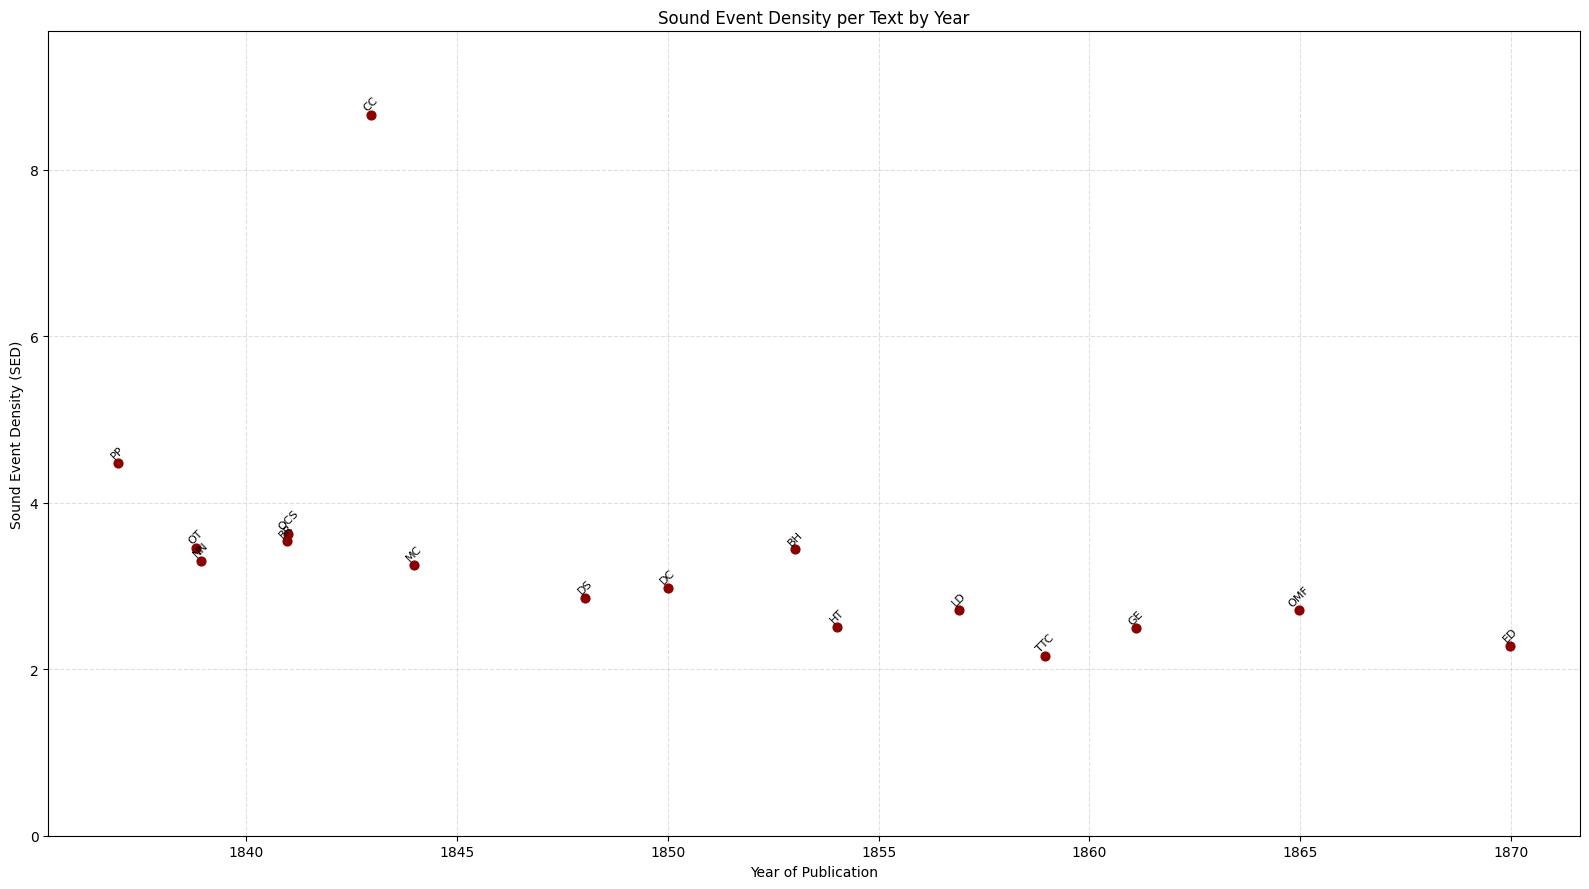

In [12]:

# Prepare data
df_plot = df[['filename', 'chosen_date', 'SED_without_nan']].copy()
df_plot = df_plot.dropna(subset=['SED_without_nan'])
df_plot = df_plot.sort_values(by='chosen_date').reset_index(drop=True)

# Jitter the x-axis slightly for same-year entries
df_plot['x'] = df_plot['chosen_date'] + np.random.normal(0, 0.1, size=len(df_plot))

# Define y-axis max
y_max = df_plot['SED_without_nan'].max() + 1

# Create the plot
plt.figure(figsize=(16, 9))
plt.scatter(df_plot['x'], df_plot['SED_without_nan'], color='darkred', s=40, zorder=2)

# Annotate each dot with filename
for i, row in df_plot.iterrows():
    plt.text(row['x'], row['SED_without_nan'] + 0.05, row['filename'], 
             fontsize=8, ha='center', rotation=45)

# Axis setup
plt.xlabel('Year of Publication')
plt.ylabel('Sound Event Density (SED)')
plt.title('Sound Event Density per Text by Year')
plt.ylim(0, y_max)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


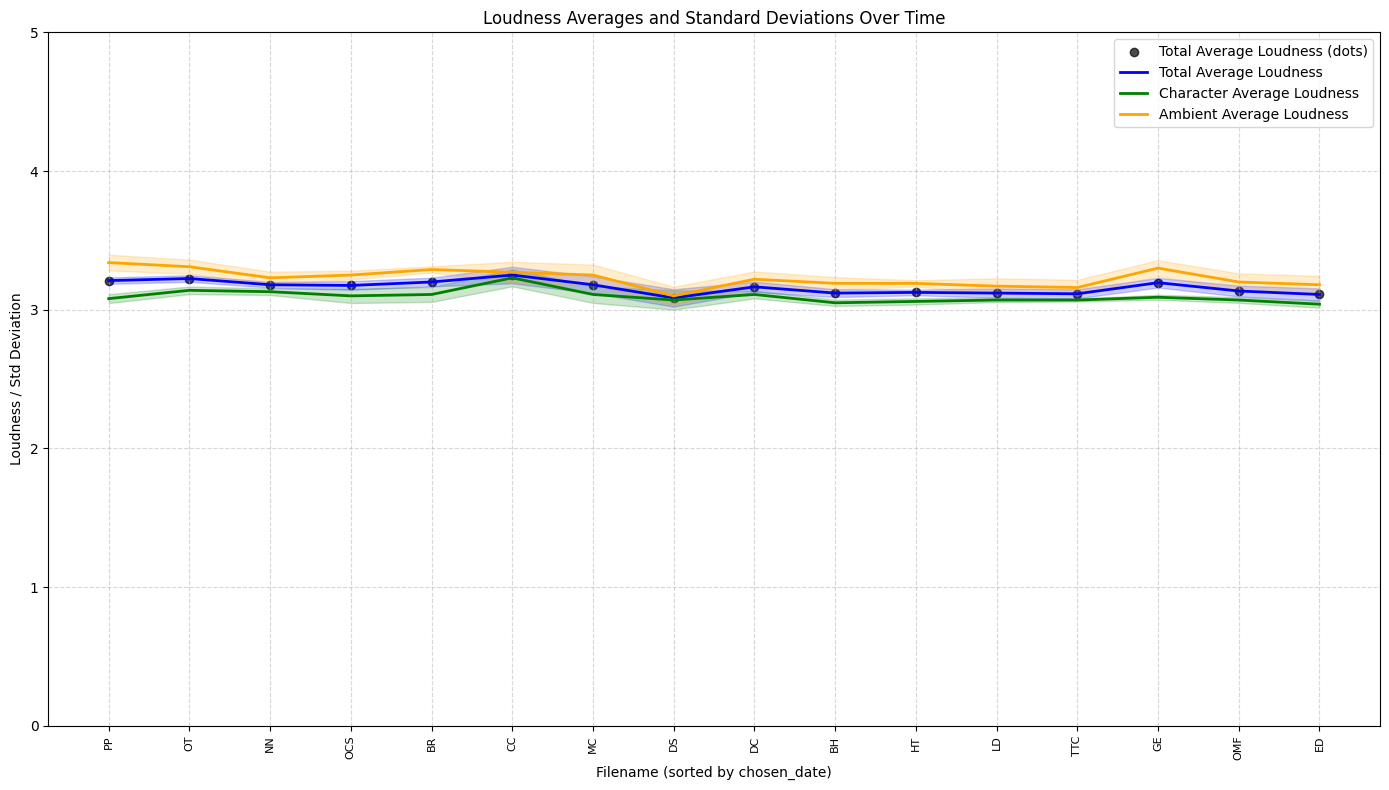

In [13]:


# Sort dataframe by chosen_date
df_sorted = df.sort_values(by='chosen_date').reset_index(drop=True)

# Prepare x-axis values
x = np.arange(len(df_sorted))  # numeric x-axis for plotting
filenames = df_sorted['filename']

# Calculate rolling std dev for smoothing or overall std
# Here, we do a rolling std with window=5 for smoothness; adjust as needed
window_size = 5

def rolling_std(series):
    return series.rolling(window=window_size, min_periods=1, center=True).std()

# Calculate rolling std devs
text_loudness_std = rolling_std(df_sorted['text_loudness_average'])
char_loudness_std = rolling_std(df_sorted['character_avg_loudness'])
ambient_loudness_std = rolling_std(df_sorted['ambient_avg_loudness'])

plt.figure(figsize=(14,8))

# Scatter dots for each filename on chosen_date (y-axis: total loudness)
plt.scatter(x, df_sorted['text_loudness_average'], label='Total Average Loudness (dots)', color='black', alpha=0.7)

# Plot line graphs for averages
plt.plot(x, df_sorted['text_loudness_average'], label='Total Average Loudness', color='blue', linewidth=2)
plt.plot(x, df_sorted['character_avg_loudness'], label='Character Average Loudness', color='green', linewidth=2)
plt.plot(x, df_sorted['ambient_avg_loudness'], label='Ambient Average Loudness', color='orange', linewidth=2)

# Plot shaded std deviation areas
plt.fill_between(x, df_sorted['text_loudness_average'] - text_loudness_std, df_sorted['text_loudness_average'] + text_loudness_std, color='blue', alpha=0.2)
plt.fill_between(x, df_sorted['character_avg_loudness'] - char_loudness_std, df_sorted['character_avg_loudness'] + char_loudness_std, color='green', alpha=0.2)
plt.fill_between(x, df_sorted['ambient_avg_loudness'] - ambient_loudness_std, df_sorted['ambient_avg_loudness'] + ambient_loudness_std, color='orange', alpha=0.2)

plt.ylim(0,5)
plt.xticks(ticks=x, labels=filenames, rotation=90, fontsize=8)
plt.xlabel('Filename (sorted by chosen_date)')
plt.ylabel('Loudness / Std Deviation')
plt.title('Loudness Averages and Standard Deviations Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


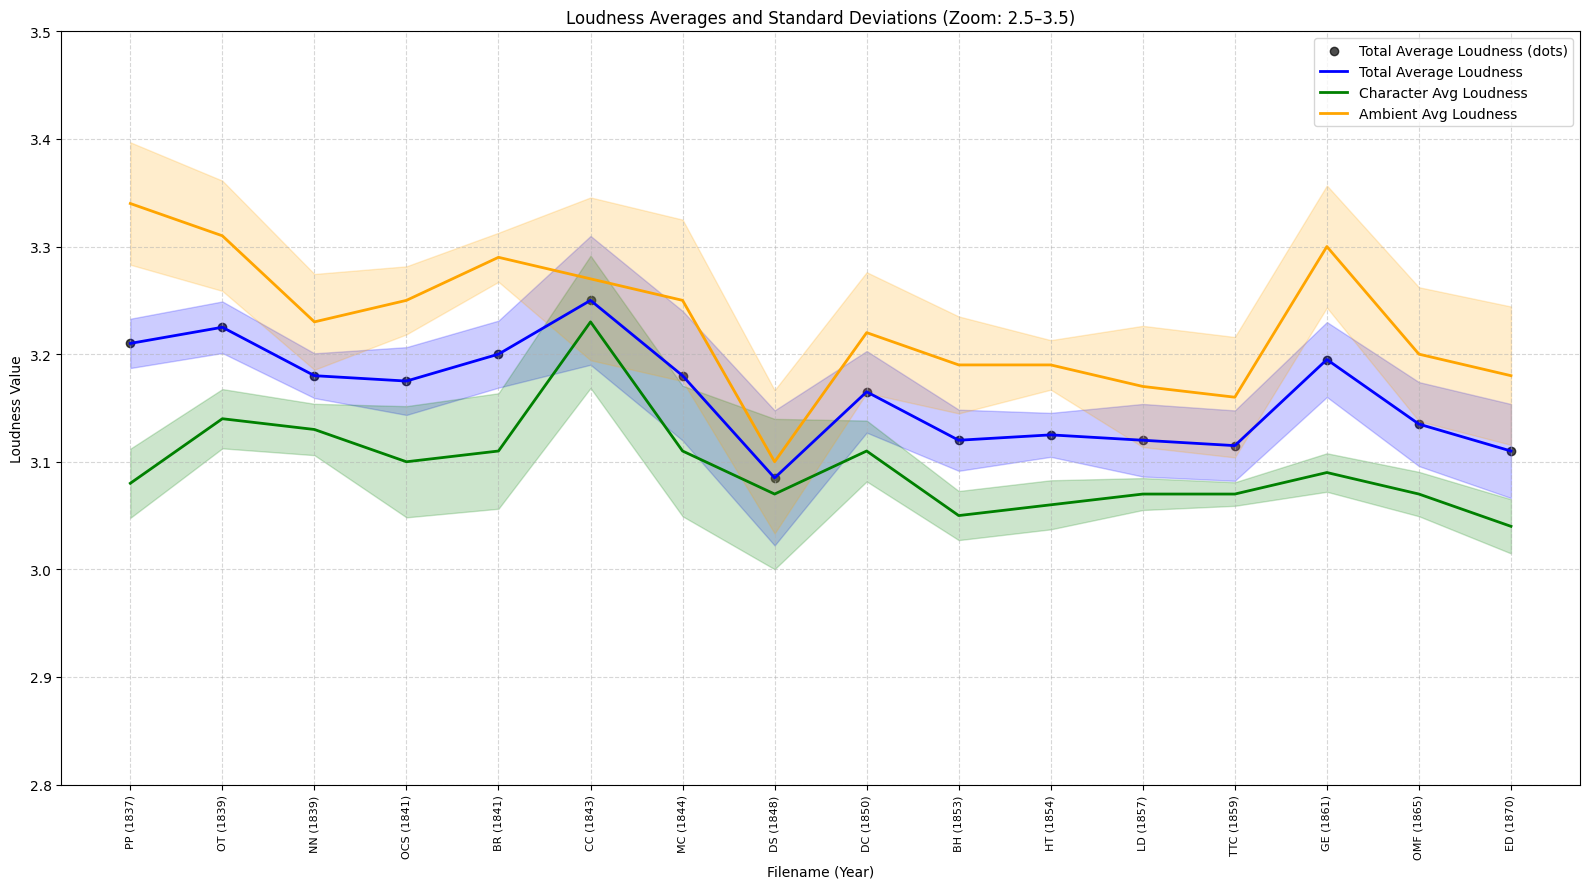

In [14]:
#Extrem cool! Loudness average + standard deviation visualized


# Sort the DataFrame by chosen_date
df_sorted = df.sort_values(by='chosen_date').reset_index(drop=True)

# Create x-axis values
x = np.arange(len(df_sorted))  # numeric index for plotting

# Create custom x-axis labels: filename + chosen_date
x_labels = df_sorted['filename'] + ' (' + df_sorted['chosen_date'].astype(str) + ')'

# Rolling standard deviations (for smoothing)
window_size = 5
def rolling_std(series):
    return series.rolling(window=window_size, min_periods=1, center=True).std()

# Calculate rolling std devs
text_loudness_std = rolling_std(df_sorted['text_loudness_average'])
char_loudness_std = rolling_std(df_sorted['character_avg_loudness'])
ambient_loudness_std = rolling_std(df_sorted['ambient_avg_loudness'])

plt.figure(figsize=(16, 9))

# Scatter plot for total average loudness
plt.scatter(x, df_sorted['text_loudness_average'], label='Total Average Loudness (dots)', color='black', alpha=0.7)

# Line plots
plt.plot(x, df_sorted['text_loudness_average'], label='Total Average Loudness', color='blue', linewidth=2)
plt.plot(x, df_sorted['character_avg_loudness'], label='Character Avg Loudness', color='green', linewidth=2)
plt.plot(x, df_sorted['ambient_avg_loudness'], label='Ambient Avg Loudness', color='orange', linewidth=2)

# Shaded std deviation areas
plt.fill_between(x, df_sorted['text_loudness_average'] - text_loudness_std,
                 df_sorted['text_loudness_average'] + text_loudness_std,
                 color='blue', alpha=0.2)
plt.fill_between(x, df_sorted['character_avg_loudness'] - char_loudness_std,
                 df_sorted['character_avg_loudness'] + char_loudness_std,
                 color='green', alpha=0.2)
plt.fill_between(x, df_sorted['ambient_avg_loudness'] - ambient_loudness_std,
                 df_sorted['ambient_avg_loudness'] + ambient_loudness_std,
                 color='orange', alpha=0.2)

# Custom x-ticks
plt.xticks(ticks=x, labels=x_labels, rotation=90, fontsize=8)

# Zoomed y-axis
plt.ylim(2.8, 3.5)

plt.xlabel('Filename (Year)')
plt.ylabel('Loudness Value')
plt.title('Loudness Averages and Standard Deviations (Zoom: 2.5–3.5)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [15]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(df['character_avg_loudness'], df['ambient_avg_loudness'], nan_policy='omit')
print("T-statistic:", t_stat, "P-value:", p_val)


T-statistic: -6.744163431139037 P-value: 1.7791813482238924e-07


In [16]:
from scipy.stats import levene

levene_stat, p_val = levene(df['character_avg_loudness'], df['ambient_avg_loudness'])
print("Levene’s statistic:", levene_stat, "P-value:", p_val)


Levene’s statistic: 2.7205100956429162 P-value: 0.10950015235449902


# Analysis of the Data

In [17]:
#For chapterwise analysis and visualization

from lxml import etree
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import re

# Load XML
with open('/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Erlangen/for_loudness_dic_anno/loudness_predicted/BH_enriched.xml', 'r', encoding='utf-8') as f:
    tree = etree.parse(f)

ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
body = tree.find('.//tei:body', namespaces=ns)

# Data containers
data = []
token_index = 0
current_chapter = 0

def tokenize(text):
    return re.findall(r'\b\w+\b', text)

def walk(element):
    global token_index, current_chapter

    # Check for chapter element
    if element.tag.endswith('chapter'):
        chapter_num = element.attrib.get('number')
        if chapter_num:
            current_chapter = int(chapter_num)

    # Handle sound elements
    if element.tag.endswith('ambient_sound') or element.tag.endswith('character_sound'):
        kind = 'ambient' if 'ambient' in element.tag else 'character'
        loudness = element.attrib.get('loudness')
        try:
            loudness_val = float(loudness)
            tokens = tokenize(element.text or "")
            for _ in tokens:
                data.append({
                    'token_position': token_index,
                    'loudness': loudness_val,
                    'type': kind,
                    'text': (element.text or "").strip(),
                    'chapter_number': current_chapter
                })
                token_index += 1
        except:
            pass
    else:
        if element.text:
            tokens = tokenize(element.text)
            token_index += len(tokens)

    for child in element:
        walk(child)
        if child.tail:
            token_index += len(tokenize(child.tail))

walk(body)

# Build DataFrame
df = pd.DataFrame(data)


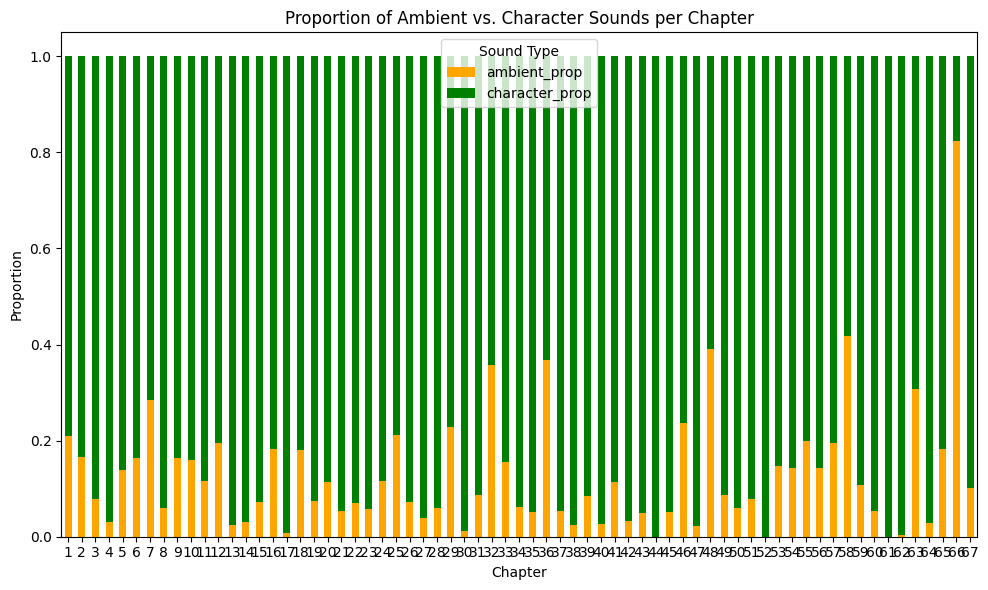

In [18]:


# Count types per chapter
chapter_df = df.groupby(['chapter_number', 'type']).size().unstack(fill_value=0)

# Add total and proportions
chapter_df['total'] = chapter_df.sum(axis=1)
chapter_df['ambient_prop'] = chapter_df.get('ambient', 0) / chapter_df['total']
chapter_df['character_prop'] = chapter_df.get('character', 0) / chapter_df['total']

# Plot
ax = chapter_df[['ambient_prop', 'character_prop']].plot(
    kind='bar',
    stacked=True,
    color=['orange', 'green'],
    figsize=(10, 6)
)
plt.title('Proportion of Ambient vs. Character Sounds per Chapter')
plt.ylabel('Proportion')
plt.xlabel('Chapter')
plt.xticks(rotation=0)
plt.legend(title='Sound Type')
plt.tight_layout()

# Save static image
plt.savefig("/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Erlangen/sound_event_visualization_white_BH.png", dpi=300)
plt.show()


In [21]:
import os
import re
from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- CONFIG ---
input_folder = '/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Erlangen/for_loudness_dic_anno/loudness_predicted'
output_folder = input_folder  # Adjust if needed

# --- Helper Functions ---

def tokenize(text):
    return re.findall(r'\b\w+\b', text)

def parse_xml_to_df(filepath):
    tree = etree.parse(filepath)
    ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
    body = tree.find('.//tei:body', namespaces=ns)

    data = []
    token_index = 0
    current_chapter = 0

    def walk(element):
        nonlocal token_index, current_chapter

        if element.tag.endswith('chapter'):
            chapter_num = element.attrib.get('number')
            if chapter_num:
                current_chapter = int(chapter_num)

        if element.tag.endswith('ambient_sound') or element.tag.endswith('character_sound'):
            kind = 'ambient' if 'ambient' in element.tag else 'character'
            loudness = element.attrib.get('loudness')
            try:
                loudness_val = float(loudness)
                tokens = tokenize(element.text or "")
                for _ in tokens:
                    data.append({
                        'token_position': token_index,
                        'loudness': loudness_val,
                        'type': kind,
                        'text': (element.text or "").strip(),
                        'chapter_number': current_chapter
                    })
                    token_index += 1
            except:
                pass
        else:
            if element.text:
                tokens = tokenize(element.text)
                token_index += len(tokens)

        for child in element:
            walk(child)
            if child.tail:
                token_index += len(tokenize(child.tail))

    walk(body)
    return pd.DataFrame(data)

def plot_and_save(df, filename_prefix):
    chapter_df = df.groupby(['chapter_number', 'type']).size().unstack(fill_value=0)
    chapter_df['total'] = chapter_df.sum(axis=1)
    chapter_df['ambient_prop'] = chapter_df.get('ambient', 0) / chapter_df['total']
    chapter_df['character_prop'] = chapter_df.get('character', 0) / chapter_df['total']

    ax = chapter_df[['ambient_prop', 'character_prop']].plot(
        kind='bar', stacked=True, color=['orange', 'green'], figsize=(10, 6)
    )
    plt.title('Proportion of Ambient vs. Character Sounds per Chapter')
    plt.ylabel('Proportion')
    plt.xlabel('Chapter')
    plt.xticks(rotation=0)
    plt.legend(title='Sound Type')
    plt.tight_layout()

    output_path = os.path.join(output_folder, f'sound_event_visualization_white_{filename_prefix}.png')
    plt.savefig(output_path, dpi=300)
    plt.show()
    print(f"✅ Plot saved to:\n{output_path}")

# --- UI: Dropdown + Button ---

xml_files = [f for f in os.listdir(input_folder) if f.endswith('.xml')]
dropdown = widgets.Dropdown(
    options=xml_files,
    description='Choose XML File:',
    layout=widgets.Layout(width='600px'),
    style={'description_width': 'initial'}
)

button = widgets.Button(description="Generate Plot", button_style='success')

output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output()
        selected_file = dropdown.value
        file_path = os.path.join(input_folder, selected_file)
        file_prefix = os.path.splitext(os.path.basename(file_path))[0]
        print(f"📂 Processing file: {selected_file}...\n")
        df = parse_xml_to_df(file_path)
        if not df.empty:
            plot_and_save(df, file_prefix)
        else:
            print("⚠️ No valid sound data found in the selected file.")

button.on_click(on_button_click)

# --- Display UI ---
display(widgets.VBox([dropdown, button, output]))


In [24]:
#For scene-wise analysis and visualization

from lxml import etree
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import re

# Load XML
with open('/Users/sguhr/Downloads/Literary_Soundscapes-main-2/loudness_predicted_DNov/CC_enriched.xml', 'r', encoding='utf-8') as f:
    tree = etree.parse(f)

ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
body = tree.find('.//tei:body', namespaces=ns)

# Data containers
data = []
token_index = 0
current_scene = 0

def tokenize(text):
    return re.findall(r'\b\w+\b', text)

def walk(element):
    global token_index, current_scene

    # Check for chapter element
    if element.tag.endswith('scene'):
        scene_num = element.attrib.get('number')
        if scene_num:
            current_scene = int(scene_num)

    # Handle sound elements
    if element.tag.endswith('ambient_sound') or element.tag.endswith('character_sound'):
        kind = 'ambient' if 'ambient' in element.tag else 'character'
        loudness = element.attrib.get('loudness')
        try:
            loudness_val = float(loudness)
            tokens = tokenize(element.text or "")
            for _ in tokens:
                data.append({
                    'token_position': token_index,
                    'loudness': loudness_val,
                    'type': kind,
                    'text': (element.text or "").strip(),
                    'scene_number': current_scene
                })
                token_index += 1
        except:
            pass
    else:
        if element.text:
            tokens = tokenize(element.text)
            token_index += len(tokens)

    for child in element:
        walk(child)
        if child.tail:
            token_index += len(tokenize(child.tail))

walk(body)

# Build DataFrame
df = pd.DataFrame(data)


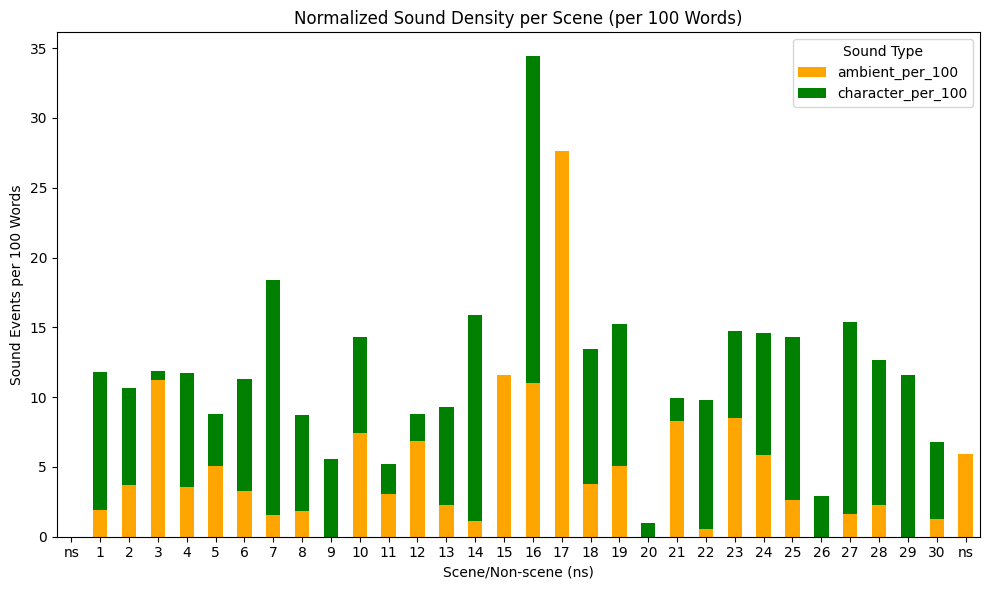

In [34]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree

# === CONFIGURATION ===
input_file = "/Users/sguhr/Downloads/Literary_Soundscapes-main-2/loudness_predicted_DNov/20250628_Updated_Loudness-annotated_DNov/CC_enriched.xml"
output_file = "/Users/sguhr/Desktop/Arbeitslaptop/TU_Darmstadt/2024:25/Vortragstournée/Erlangen/sound_event_visualization_white_CC_scenewise.png"

# === UTILITIES ===
def tokenize(text):
    return re.findall(r'\b\w+\b', text)

# === XML PROCESSING ===
ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
with open(input_file, 'r', encoding='utf-8') as f:
    tree = etree.parse(f)

body = tree.find('.//tei:body', namespaces=ns)
data = []
token_index = 0

# We'll keep scene labels keyed by our scene_counter
scene_word_counts = {}
scene_labels = {}

scene_counter = 0  # our internal counter

def walk(element):
    global token_index, scene_counter

    tag = etree.QName(element.tag).localname

    # Detect scene/non-scene with label
    if tag == 'scene' or tag == 'non-scene':
        scene_counter += 1
        
        # For scene, get 'counter' or 'number' attribute for label
        if tag == 'scene':
            # Prefer 'counter', fallback to 'number', else use scene_counter as string
            label = element.attrib.get('counter') or element.attrib.get('number') or str(scene_counter)
        else:
            label = 'ns'  # non-scene label
        
        scene_labels[scene_counter] = label
        scene_word_counts[scene_counter] = 0

        # Walk children within this scene/non-scene
        for child in element:
            walk(child)
            if child.tail:
                wc = len(tokenize(child.tail))
                scene_word_counts[scene_counter] += wc
                token_index += wc
        return

    if tag in ['ambient_sound', 'character_sound']:
        kind = 'ambient' if 'ambient' in tag else 'character'
        loudness = element.attrib.get('loudness')
        try:
            loudness_val = float(loudness)
            tokens = tokenize(element.text or "")
            for _ in tokens:
                data.append({
                    'token_position': token_index,
                    'loudness': loudness_val,
                    'type': kind,
                    'text': (element.text or "").strip(),
                    'scene_number': scene_counter
                })
                token_index += 1
                scene_word_counts[scene_counter] += 1
        except:
            pass
    else:
        if element.text:
            wc = len(tokenize(element.text))
            token_index += wc
            if scene_counter in scene_word_counts:
                scene_word_counts[scene_counter] += wc

    for child in element:
        walk(child)
        if child.tail:
            wc = len(tokenize(child.tail))
            token_index += wc
            if scene_counter in scene_word_counts:
                scene_word_counts[scene_counter] += wc

walk(body)

# === BUILD DATAFRAME ===
df = pd.DataFrame(data)

# === AGGREGATE BY SCENE ===
scene_df = df.groupby(['scene_number', 'type']).size().unstack(fill_value=0)

# Add zero rows for scenes with no sounds
for sc in scene_word_counts.keys():
    if sc not in scene_df.index:
        scene_df.loc[sc] = {'ambient': 0, 'character': 0}

scene_df = scene_df.sort_index()

# === NORMALIZE PER 100 WORDS ===
scene_df['words'] = pd.Series(scene_word_counts)
scene_df['ambient_per_100'] = scene_df.get('ambient', 0) / scene_df['words'] * 100
scene_df['character_per_100'] = scene_df.get('character', 0) / scene_df['words'] * 100

# === PLOT ===
ax = scene_df[['ambient_per_100', 'character_per_100']].plot(
    kind='bar',
    stacked=True,
    color=['orange', 'green'],
    figsize=(10, 6)
)

plt.title('Normalized Sound Density per Scene (per 100 Words)')
plt.ylabel('Sound Events per 100 Words')
plt.xlabel('Scene/Non-scene (ns)')

# Replace x-ticks with scene labels
ax.set_xticks(range(len(scene_labels)))
ax.set_xticklabels([scene_labels[i+1] for i in range(len(scene_labels))], rotation=0)

plt.legend(title='Sound Type')
plt.tight_layout()

# === SAVE ===
plt.savefig(output_file, dpi=300)
plt.show()
